In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.sparse as ss
from sklearn import linear_model, metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

def rmse(X, y):
    return np.sqrt(metrics.mean_squared_error(X, y))


def mape(X, y):
    return abs(np.divide(y - X, y)).sum()/y.size


def summarize(y, y_pred):
    print(f"rmse: {rmse(y, y_pred)}")
    print(f"mape: {mape(y, y_pred)}")
    plt.figure(figsize=(16, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.plot(y[i].T, label="y")
        plt.plot(y_pred[i].T, label="$\hat{y}$")
        plt.legend()
    plt.show()

    
def plot_scree(g):
    L = nx.laplacian_matrix(g).astype("float64")
    k = 64
    w, v = ss.linalg.eigsh(L, k=k)
    plt.title("scree plot of laplacian eigenvalues")
    plt.plot(np.arange(k), w[::-1])
    plt.show()

    
def laplacian_embedding(g, dim):
    L = nx.laplacian_matrix(g).astype("float64")
    w, v = ss.linalg.eigsh(L, k=dim+1)
    return np.divide(v[:,:-1], np.sqrt(w[:-1]))[::-1]


def create_dataset(ts, window_size=7, n_panes=14):
    # fill missing days with very small values
    X = ts.iloc[:,1:].fillna(1e-6).values
    T = X.shape[1]
    window_size = 7

    # Create a new matrix for every row that is matrix of size (T//window_size, window_size)
    indexer = (
        np.arange(window_size).reshape(1, -1) 
        + window_size*np.arange(T//window_size).reshape(-1, 1)
    )

    # A pane is made up of many windows
    panes = X[:,indexer]

    # by default, concatenate 4*3 windows, or 3 months of data, for the training data
    train = panes[:,:n_panes-2,:].reshape(panes.shape[0],-1)

    # we benchmark this against using the previous week's day
    validate = panes[:,n_panes-1,:]
    
    # the test data is the final week
    test = panes[:,n_panes,:]
    
    return train, validate, test


def run_trial(mapping, edges, ts):
    g = nx.subgraph(
        nx.from_pandas_edgelist(
            edges, 
            source="src", 
            target="dst",
            create_using=nx.Graph
        ),
        ts.id
    )
    print(nx.info(g))
    plot_scree(g)
    emb = laplacian_embedding(g, 8)
    train, validate, test = create_dataset(ts, 7, 54)
    
    print("using x^{(t-1)}")
    summarize(test, validate)
    
    print("using the mean of the last week")
    summarize(test, (np.ones(test.shape).T*validate.mean(axis=1)).T)

    print("linear regression")
    model = linear_model.LinearRegression()
    model.fit(train, validate)
    test_X = np.hstack([train[:,7:], validate])
    summarize(test, model.predict(test_X))

    print("linear regression with pagerank features")
    model = linear_model.LinearRegression()
    pr_col = np.array([ts.merge(mapping).pagerank.values]).T
    z = np.hstack([train, pr_col])
    model.fit(z, validate)
    z = np.hstack([test_X, pr_col])
    summarize(test, model.predict(z))

    print("linear regression with emb features")
    model = linear_model.LinearRegression()
    z = np.hstack([train, emb])
    model.fit(z, validate)
    z = np.hstack([test_X, emb])
    summarize(test, model.predict(z))

    print("weighted linear regression with pagerank weights")
    model = linear_model.Ridge(alpha=0)
    model.fit(train, validate, pr_col.T[0])
    summarize(test, model.predict(test_X))
    
    print("weighted regression using nearest neighbors")
    #weights = np.linalg.norm((emb[:,:,np.newaxis] + emb.T).mean(axis=1), axis=1)
    #weights = np.linalg.norm(emb, axis=1)
    tree = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(emb)
    _, ind = tree.kneighbors(emb)
    
    # TODO: something more rigorous than the mean of the embeddings
    weights = np.linalg.norm(emb[ind[:,1:]].mean(axis=1), axis=1)

    model = linear_model.Ridge(alpha=0)
    model.fit(train, validate, weights)
    summarize(test, model.predict(test_X))

    print("decision tree without emb")
    model = DecisionTreeRegressor()
    model.fit(train, validate)
    summarize(test, model.predict(test_X))

    print("decision tree with emb")
    model = DecisionTreeRegressor()
    z = np.hstack([train, emb])
    model.fit(z, validate)
    z = np.hstack([test_X, emb])
    summarize(test, model.predict(z))
    

Name: 
Type: Graph
Number of nodes: 1247
Number of edges: 30205
Average degree:  48.4443


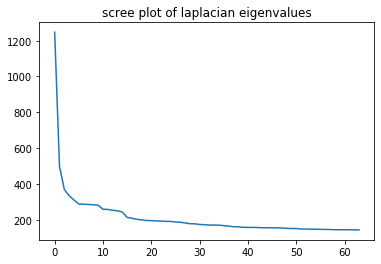

using x^{(t-1)}
rmse: 970.1508116896341
mape: 3030702.3319764556


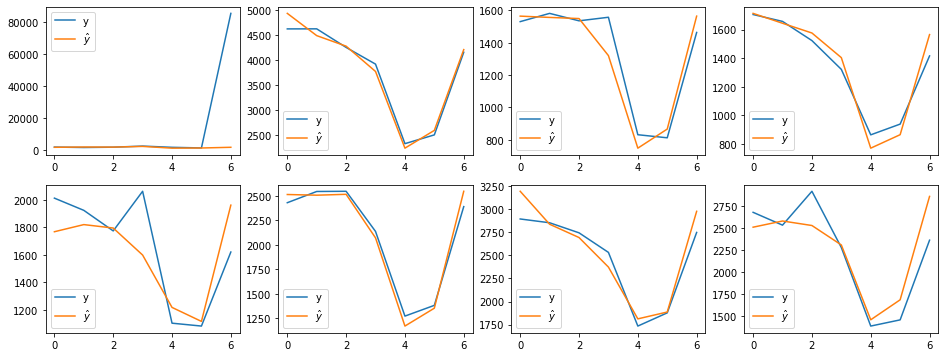

using the mean of the last week
rmse: 964.1413027661321
mape: 1086149.8927736091


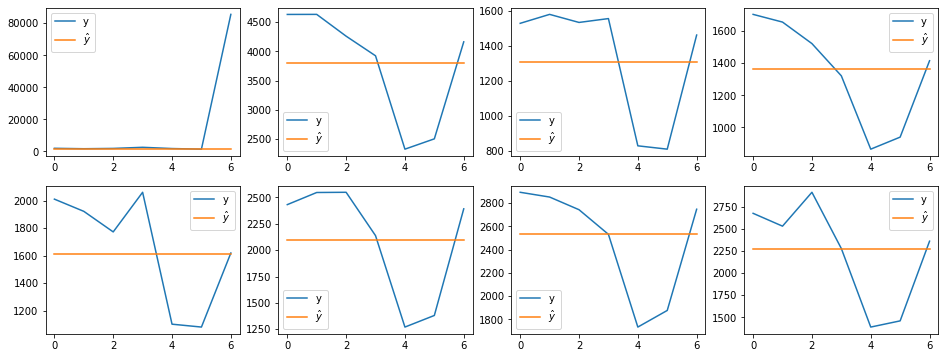

linear regression
rmse: 1043.772612032451
mape: 1.010073049830106


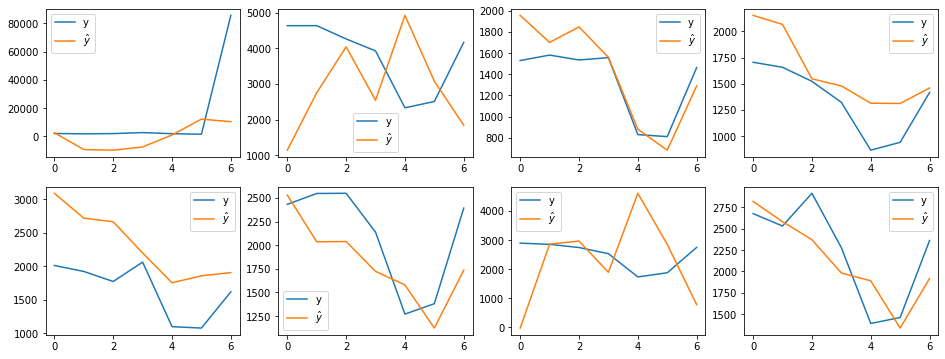

linear regression with pagerank features
rmse: 1078.2326329684556
mape: 1.2218703487487135


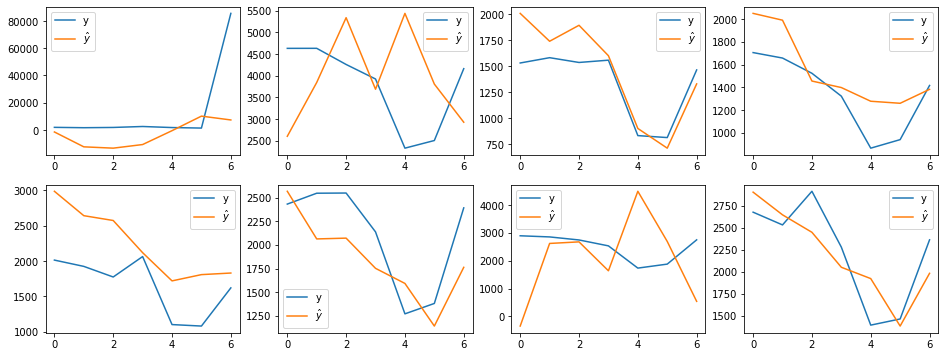

linear regression with emb features
rmse: 1052.4309657132192
mape: 1.5658312374391101


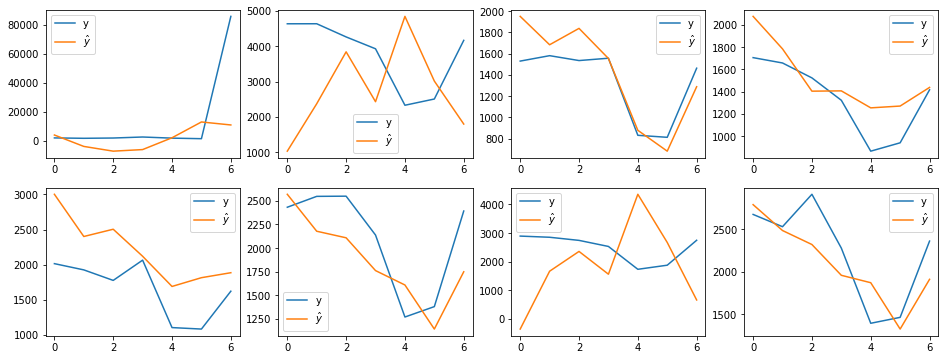

weighted linear regression with pagerank weights
rmse: 1035.2076756541633
mape: 0.9363562106978748


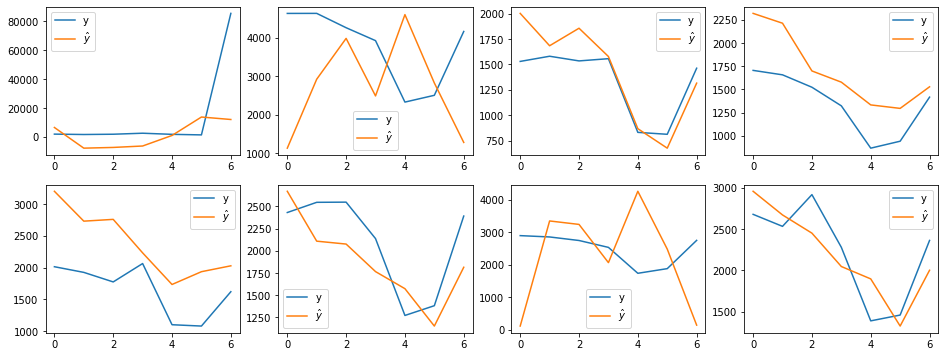

weighted regression using nearest neighbors
rmse: 976.7235892795585
mape: 1.233341898465437


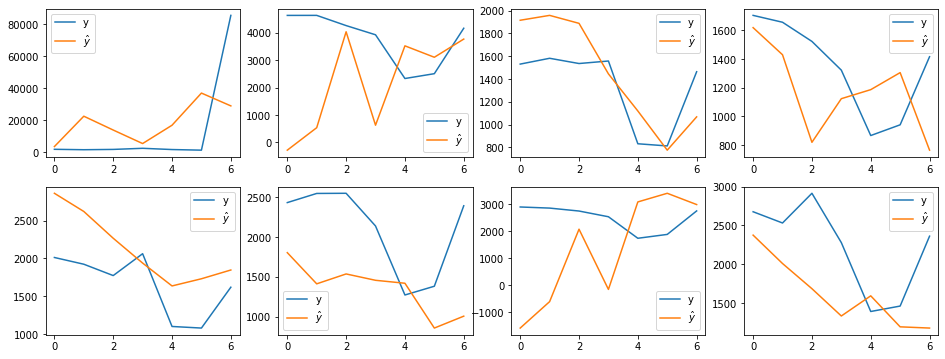

decision tree without emb
rmse: 969.9569059288528
mape: 6875702.025325704


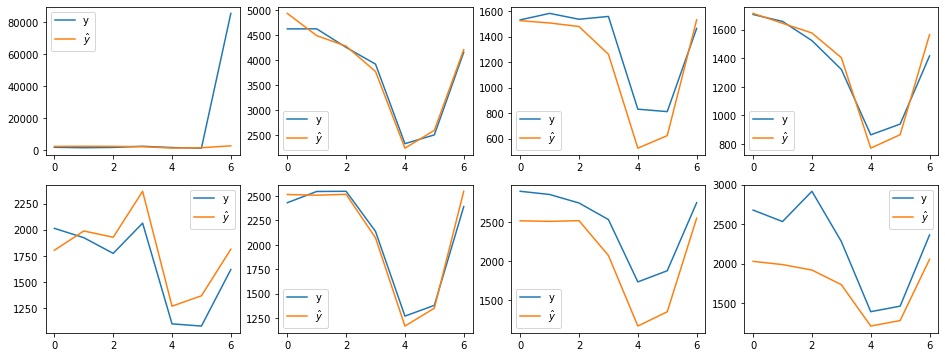

decision tree with emb
rmse: 976.7378547211035
mape: 5309772.143630009


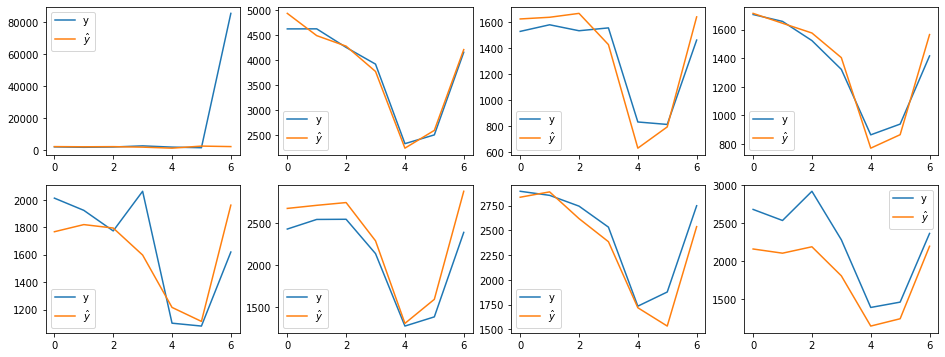

Neural Network
rmse: 1052.3344182484366
mape: 5.670623992888132


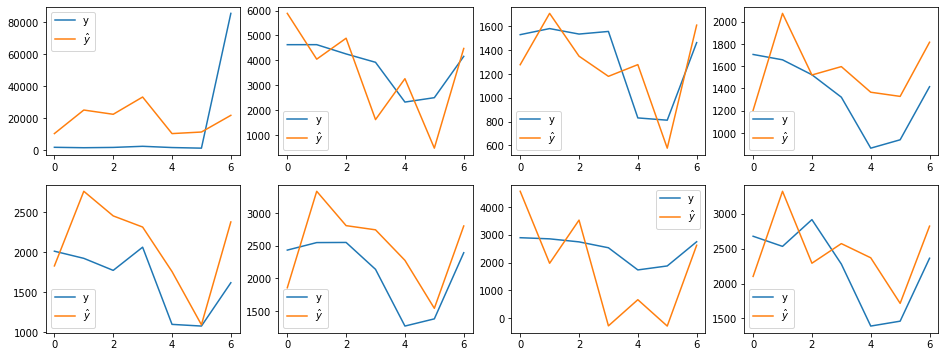

Neural Network with Pagerank features
rmse: 951.6166331518773
mape: 1.7747219581164655


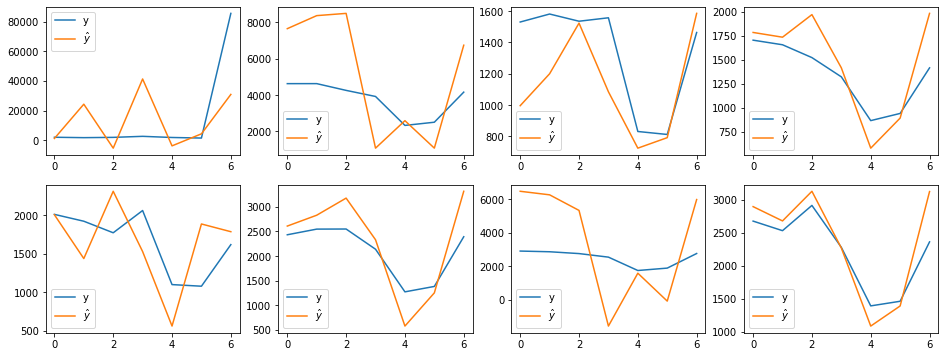

Neural Network with Embedding
rmse: 1031.9158103186041
mape: 2.256799873426365


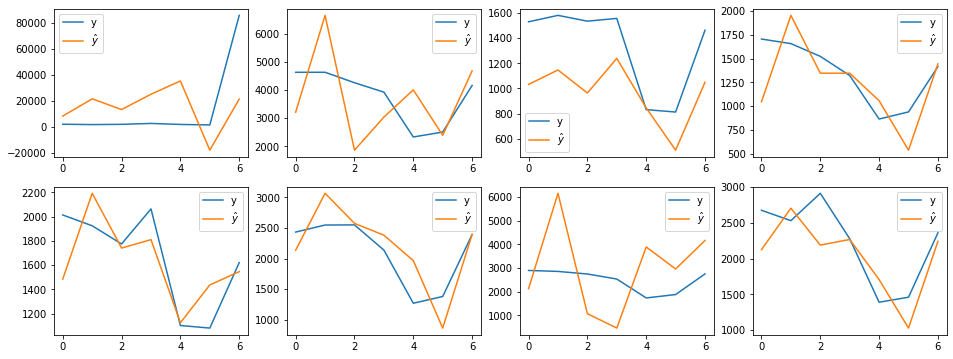

In [9]:
mapping = pd.read_csv("../sample_data/trial_6/mapping.csv")
edges = pd.read_csv('../sample_data/trial_6/edges.csv')
ts = pd.read_csv("../sample_data/trial_6/ts.csv")
run_trial(mapping, edges, ts)

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

pages_path = "../data/enwiki/pages"
pagelinks_path = "../data/enwiki/pagelinks"
pageviews_path = "../data/enwiki/pagecount_daily_v2"

spark = SparkSession.builder.getOrCreate()
pages = spark.read.parquet(pages_path)
pagelinks = spark.read.parquet(pagelinks_path)
pageviews = spark.read.parquet(pageviews_path)

# pages.printSchema()
# pagelinks.printSchema()
# pageviews.printSchema()


def sample_random(pages, links, views):
    nodes = pages.sample(0.05)
    edges = (
        links.join(nodes.selectExpr("id as from"), on="from")
        .join(nodes.selectExpr("id as dest"), on="dest")
    ).selectExpr("from as src", "dest as dst")
    ts = (
        views.join(nodes, on=views["page_id"] == nodes["id"])
        .where("date is not null")
        .groupBy("id")
        .pivot("date")
        .agg(F.min("count"))
    )
    return nodes.toPandas(), edges.toPandas(), ts.toPandas()


def create_dataset_from_parquet(pages, links, views):
    mapping, edges, ts = sample_random(pages, links, views)

    # get subgraph and compute pagerank
    g = nx.subgraph(
        nx.from_pandas_edgelist(
            edges, 
            source="src", 
            target="dst",
            create_using=nx.DiGraph
            ),
        ts.id
    )
    print(f"sampled graph has {g.number_of_nodes()}")
    pr = nx.pagerank(g)
    ordered = sorted(pr.keys(), key=pr.get, reverse=True)
    
    # only keep the largest connected component, top pagerank node is most likely to be part of
    # the largest fully connected component
    g = nx.Graph(g).subgraph(nx.node_connected_component(nx.Graph(g), ordered[0]))
    print(f"largest component has {g.number_of_nodes()}")

    # create a list sorted by pagerank
    connected = (
        pd.DataFrame({"id": g.nodes(), "pagerank": [pr[x] for x in g.nodes()]})
        .sort_values("pagerank", ascending=False)
    )
    return connected.merge(mapping), edges, connected.merge(ts).drop("pagerank", axis=1)

AnalysisException: 'Path does not exist: file:/Users/nicogarcia/Documents/Stanford/Senior/fall-2019/cs-229/cs229-f19-wiki-forecast/data/enwiki/pages;'

In [4]:
%time mapping, edges, ts = create_dataset_from_parquet(pages, pagelinks, pageviews)

sampled graph has 39526
largest component has 36900
CPU times: user 19 s, sys: 840 ms, total: 19.9 s
Wall time: 54.1 s


Name: 
Type: Graph
Number of nodes: 36900
Number of edges: 166411
Average degree:   9.0196


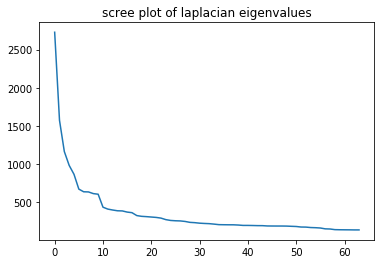

using x^{(t-1)}
rmse: 459.054197430196
mape: 3719821.955272462


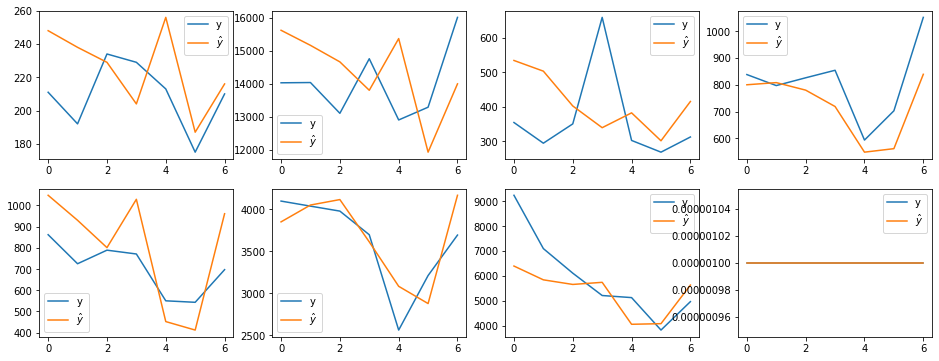

using the mean of the last week
rmse: 416.6618611697033
mape: 1608385.7776942607


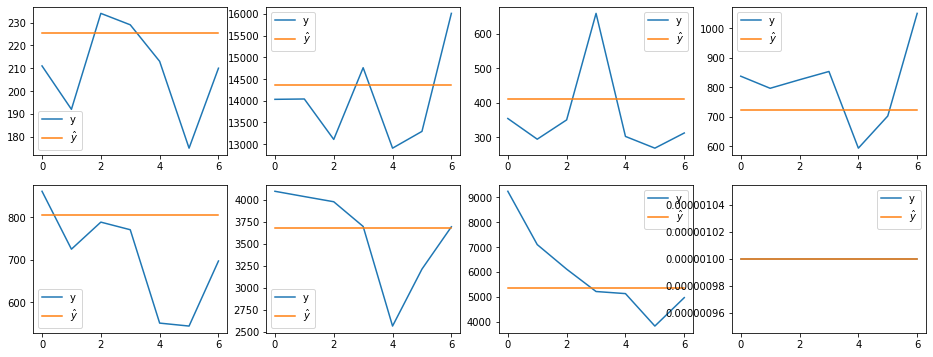

linear regression
rmse: 700.6035469295127
mape: 1.8033249114085932


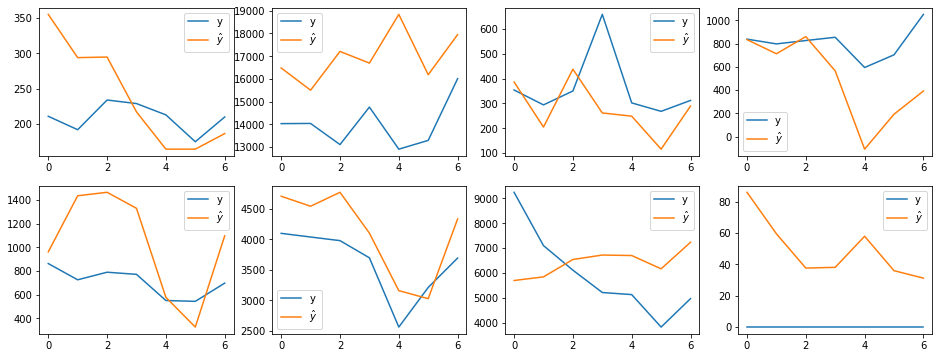

linear regression with pagerank features
rmse: 702.2430874311286
mape: 1.9262756111019053


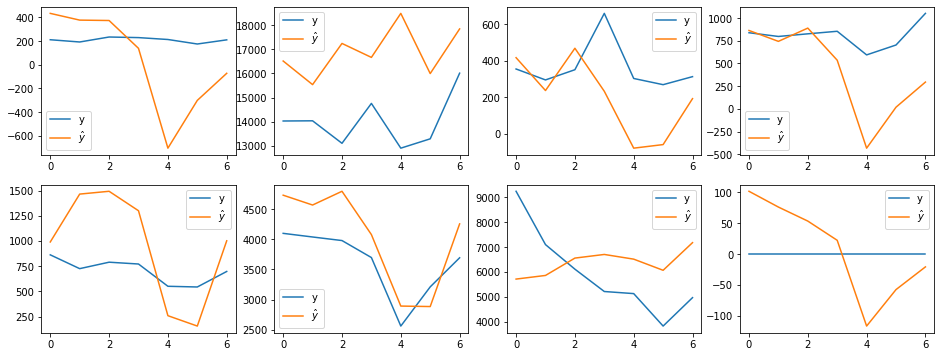

linear regression with emb features
rmse: 700.6892405594824
mape: 1.7302834703069883


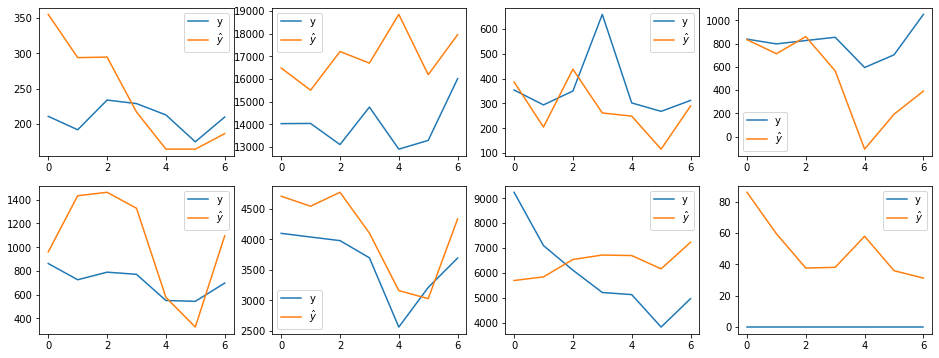

weighted linear regression with pagerank weights
rmse: 734.0258568889885
mape: 2.1240967642796944


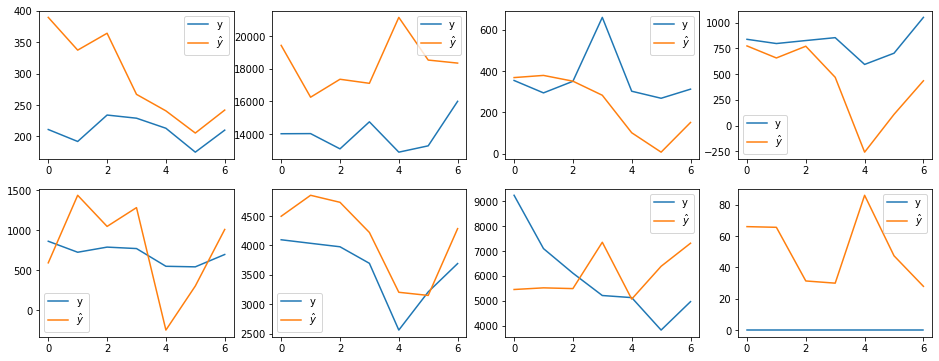

weighted regression using nearest neighbors
rmse: 529.15371167638
mape: 1.723854385909163


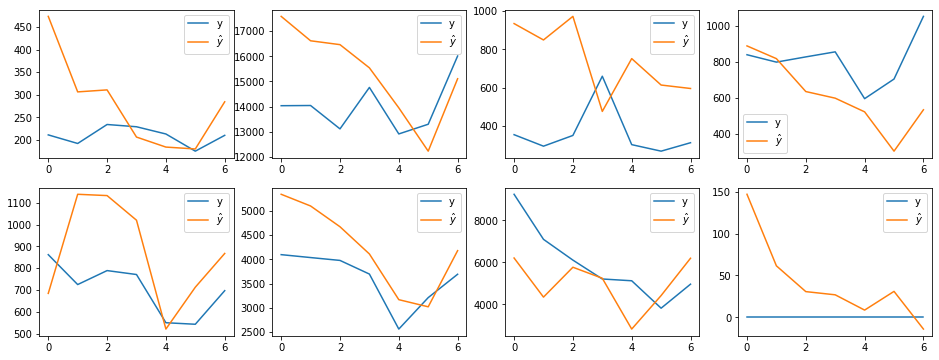

decision tree without emb
rmse: 542.6493368246361
mape: 4587580.679096579


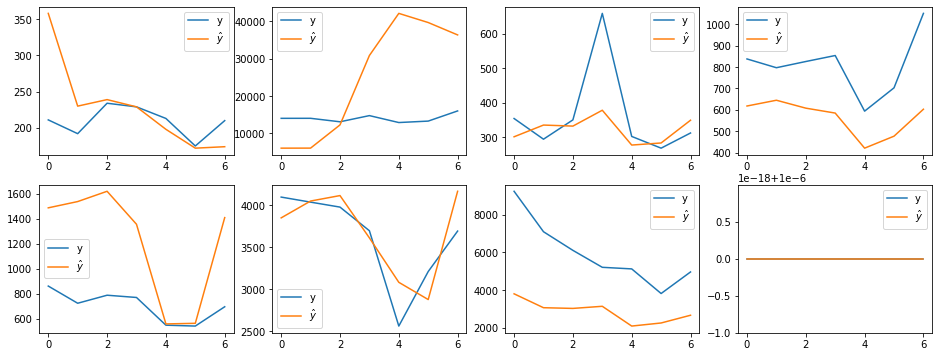

decision tree with emb
rmse: 534.3668830042187
mape: 4744913.256043812


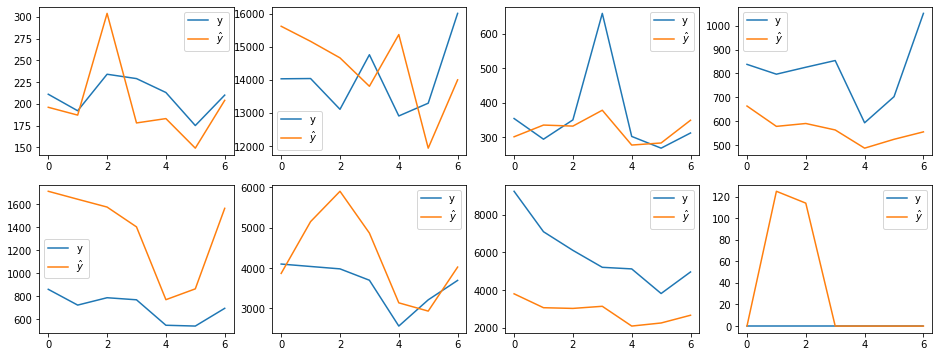

In [5]:
run_trial(mapping, edges, ts)